In [2]:
!pip install tensorflow


In [3]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import re
import gc
import glob
import seaborn as sns
import tensorflow as tf
from mlxtend.plotting import plot_confusion_matrix
from tensorflow import keras 
from keras.models import Sequential, Model, load_model
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam,SGD
from keras import backend as K
from tensorflow.python.framework import ops
from time import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,roc_auc_score
from keras import regularizers
import datetime
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Input,Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.nn import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization

In [6]:
 pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
 conda install -c conda-forge opencv

In [2]:
pip install mlxtend  

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install keras-layer-normalization

  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4667 sha256=ed31cb796860523a5798f376f99b31ff355dab37d4c944ce86e9a540fd91e697
  Stored in directory: c:\users\computing\appdata\local\pip\cache\wheels\d7\2b\f4\28f4bab995fa99c26b761bc7f9aeb5bf6c81e9be6ccd0b853b
Successfully built keras-layer-normalization
Note: you may need to restart the kernel to use updated packages.


In [21]:
train = r'C:\Users\Computing\Downloads\data-task1\train'
val   = r'C:\\Users\Computing\Downloads\data-task1\val'
test  = r'C:\\Users\Computing\Downloads\data-task1\test'

In [62]:
batch_size = 128
num_classes = 10
epochs = 12

In [37]:
# list has two lists inside, where the first one includes images with pneumonia and the second one includes normal images
class_names = os.listdir(train)
test_image_files = [[os.path.join(test, class_name, x) 
               for x in os.listdir(os.path.join(test, class_name))] 
               for class_name in class_names]

train_image_files_first = [[os.path.join(train, class_name, x) 
               for x in os.listdir(os.path.join(train, class_name))] 
               for class_name in class_names]

train_with_pneumonia = train_image_files_first[0][:len(train_image_files_first[0]) // 2]
train_with_norm = train_image_files_first[1]
train_image_files = [train_with_pneumonia,  train_with_norm]

valid_image_files = [[os.path.join(val, class_name, x) 
               for x in os.listdir(os.path.join(val, class_name))] 
               for class_name in class_names]

In [39]:
print("Size of training set: ")
print(f"Number of images with pneumonia: {len(train_image_files_first[0])} and with no_pneomonia {len(train_image_files_first[1])}\n")

print("Size of test set: ")
print(f"Number of images with pneumonia: {len(test_image_files[0])} and with no_pneomonia {len(test_image_files[1])}\n")

print("Size of validation set: ")
print(f"Number of images with pneumonia: {len(valid_image_files[0])} and with no_pneomonia {len(valid_image_files[1])}")

Size of training set: 
Number of images with pneumonia: 2358 and with no_pneomonia 642

Size of test set: 
Number of images with pneumonia: 395 and with no_pneomonia 105

Size of validation set: 
Number of images with pneumonia: 390 and with no_pneomonia 110


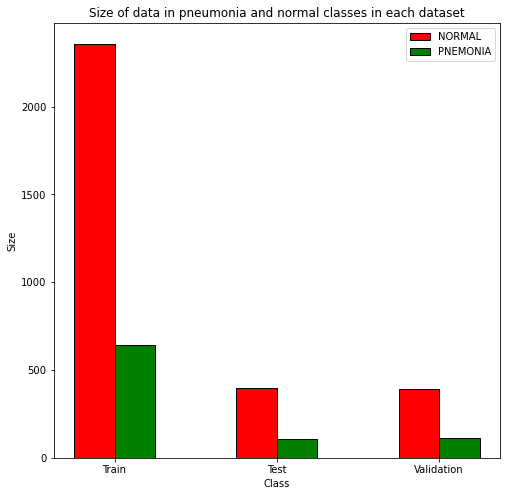

In [42]:
pn = [len(train_image_files_first[0]), len(test_image_files[0]), len(valid_image_files[0])]
norm = [len(train_image_files_first[1]), len(test_image_files[1]), len(valid_image_files[1])]
  
r = np.arange(3)
width = 0.25

fig = plt.figure(figsize = (8, 8))

plt.bar(r, pn, color = 'r',
        width = width, edgecolor = 'black',
        label='NORMAL')
plt.bar(r + width, norm, color = 'g',
        width = width, edgecolor = 'black',
        label='PNEMONIA')
  
plt.xlabel("Class")
plt.ylabel("Size")
plt.title("Size of data in pneumonia and normal classes in each dataset")
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2, ['Train','Test','Validation'])
plt.legend()
  
plt.show()

In [44]:
def plot_performance_metrics(model):
  tr_loss = model.history['loss']
  val_loss = model.history['val_loss']
  tr_f1 = model.history['f1']
  val_f1 = model.history['val_f1']
    
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
  plt.subplots_adjust(wspace=0.40)

# Loss Plot
  ax1.plot(tr_loss)
  ax1.plot(val_loss)
  ax1.grid()
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend(['Train Loss', 'Test Loss'], loc='upper left')
  ax1.set_title('Plot of Train and Test Loss against Epochs')
# F1-Score Plot
  ax2.plot(tr_f1)
  ax2.plot(val_f1)
  ax2.grid()
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('F1 Score')
  ax2.legend(['Train F1-Score', 'Test F1-Score'], loc='upper left')
  ax2.set_title('Plot of Train and Test F1-Score against Epochs')
  
  plt.show()

In [45]:
#PRDICTION FUNCTION FOR SIGMOID
def predict_classes(predictions):
    valResult = predictions.copy()
    valResult[valResult <= 0.5] = 0  
    valResult[valResult > 0.5] = 1   
    return valResult

In [48]:
# Function for Confusion Matrix.
def plot_confusion_matrix(predictions, labels):
    valResult = predict_classes(predictions)    
    conf_matrix_df= pd.DataFrame(confusion_matrix(labels,valResult), index=["Normal", "Pneumonia"],columns=["Normal", "Pneumonia"])
    plt.figure(figsize=(7,6))
    plt.title("Confusion Matrix")   
    sns.heatmap(conf_matrix_df, annot=True,  annot_kws={"size" : "20"},  fmt='.4g')   
    plt.xlabel('\nPredicted',fontsize=12)    
    plt.ylabel('Actual', fontsize=12,rotation='horizontal',labelpad=40)
    
# Get TP, FP, TN and FN
    cm = confusion_matrix(labels, valResult) 
    print('='*50)                                
    print('True Positive  (TP) = ', cm[0][0])
    print('False Positive (FP) = ', cm[0][1])
    print('False Negative (FN) = ', cm[1][0])
    print('True Negative  (TN) = ', cm[1][1])
    print('-'*26)
    
# Get Precision, Recall and F1 Score

    if (cm[0][0] + cm[0][1])!=0 and (cm[0][0], cm[1][0])!=0:
      precision= round((cm[0][0] / (cm[0][0] + cm[0][1]))*100, 2) 
      recall   = round((cm[0][0] / (cm[0][0] + cm[1][0]))*100, 2) 
      f1_score = round(2*((precision*recall)/(precision+recall)), 2)       
      print(f'Precision Score: {precision}%')
      print(f'Recall Score: {recall}%')
      print(f'F1 Score: {f1_score}%')
      print('='*50) 
      print('\n')
        
# Function for ROC curve.
def plot_roc_curve(predictions, labels):
    fpr, tpr, thresholds = roc_curve(labels, predictions) 
    auc = roc_auc_score(validation_generator.classes, prediction) 
    plt.title('Receiver Operating Characteristic (ROC)  Curve',fontsize=14)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot(fpr, tpr, 'g',label = 'AUC Score = %0.2f' % auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('\nTrue Positive Rate (TPR)', fontsize=12)
    plt.xlabel('\nFalse Positive Rate (FPR)', fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()

In [54]:
def f1(y_true, y_pred):    
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall    
    def precision(y_true, y_pred):
       
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +  K.epsilon())
        return precision    
        precision = precision(y_true, y_pred)
        recall = recall(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [58]:
model = Sequential([
    Conv2D(32, (3,3), activation=relu, input_shape=(224,241, 1)),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, (3,3), activation=relu),  
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(128, (3,3), activation=relu), 
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(128, (3,3), activation=relu), 
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dropout(0.5),
    
    Dense(512, activation=relu),
    Dropout(0.5),
    
    Dense(512, activation=relu),
    Dense(1, activation=sigmoid)
])# Compiling the model.
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy', 
              metrics=[f1])# Summary of Architecture.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 239, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 119, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 117, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 58, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 28, 128)     

In [64]:
trainDataGen = ImageDataGenerator(rescale = 1./255,rotation_range = 9, zoom_range = 0.2,width_shift_range = 0.2, height_shift_range = 0.2)

validationDataGen = ImageDataGenerator(rescale = 1./255,
                                       rotation_range = 9,
                                       zoom_range = 0.2,
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.2)# Train  
train_generator = trainDataGen.flow_from_directory(
                  train,
                  target_size = (224, 241),
                  batch_size = batch_size,
                  class_mode = 'binary',
                  color_mode = 'grayscale')# Test
validation_generator = validationDataGen.flow_from_directory(
                       test,
                       target_size = (224, 241),
                       batch_size = batch_size,
                       class_mode = 'binary',
                       color_mode = 'grayscale',
                       shuffle = False)

Found 3000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [69]:
# Tensorboard
# Load the TensorBoard notebook extension.
%load_ext tensorboard
# Storing the event files in 'logs/Model_1_'
folder.log_dir="logs/Model_1_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
# EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              baseline=None, 
                              restore_best_weights=True, 
                              patience = 8,
                              verbose = 1)# Defining train and val steps required during model fitting.
validation_steps = validation_generator.samples // batch_size
# (624/16 = 39)
training_steps   = train_generator.samples // batch_size        
# (5216/16= 326)# Fit the model.
model_1 = model.fit_generator(
          generator = train_generator,
          steps_per_epoch = training_steps,
          epochs = 100,
          validation_data = validation_generator,
          validation_steps = validation_steps, 
          callbacks = [tensorboard_callback, earlyStopping])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


NameError: name 'folder' is not defined